In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import jax
import jax.numpy as jnp
import haiku as hk
from jax import random
from jax import nn
from jax import vmap
from jax import grad

import tensorflow as tf
from jax.experimental import jax2tf
import tf2onnx
import onnx
import onnxruntime as ort

In [54]:
data_df = pd.read_csv('./data/train.csv')

np.random.shuffle(data_df.values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)
# Reshape from flattened pixels into [C, H, W] format for tensorrt inferencing
X = X.reshape(42000, 1, 28, 28)

X_train = X[1000:]
X_train = X_train / 255.
Y_train = Y[1000:]

X_val = X[:1000]
X_val = X_val / 255.
Y_val = Y[:1000]

In [55]:
X.shape

(42000, 1, 28, 28)

In [50]:
X.reshape(42000, 1, 28, 28).shape
Y.reshape(42000, 1, 28, 28).shape

(42000, 1, 28, 28)

In [83]:
def _forward_fn(x):
    mlp = hk.Sequential([
        hk.Flatten(),
        hk.Linear(10), jax.nn.relu,
        hk.Linear(10), jax.nn.softmax
    ])
    return mlp(x)

In [84]:
forward_fn = hk.transform(_forward_fn)

In [88]:
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)

initial_params = forward_fn.init(rng=rng_key, x=dummy_x)

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape, initial_params[layer_name]["b"].shape))

linear
Weights : (784, 10), Biases : (10,)

linear_1
Weights : (10, 10), Biases : (10,)



In [89]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    A2 = forward_fn.apply(params, rng_key, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(A2)) / m
    return loss


def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params

In [90]:
def get_predictions(A2):
    return jnp.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng=rng, x=X)
    for i in range(iterations):
        params = update_params(params, alpha, X, Y)
        if i % 10 == 0:
            print("Iteration: ", i)
            A2 = forward_fn.apply(params, rng, X)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return params

In [91]:
params = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
0.1612439
Iteration:  10
0.35799998
Iteration:  20
0.59926826
Iteration:  30
0.6922439
Iteration:  40
0.727
Iteration:  50
0.75258535
Iteration:  60
0.776878
Iteration:  70
0.79597557
Iteration:  80
0.8117317
Iteration:  90
0.8239024
Iteration:  100
0.83402437
Iteration:  110
0.84197557
Iteration:  120
0.848439
Iteration:  130
0.8546097
Iteration:  140
0.85924387
Iteration:  150
0.86375606
Iteration:  160
0.8674878
Iteration:  170
0.87053657
Iteration:  180
0.87365854
Iteration:  190
0.8766829
Iteration:  200
0.8798536
Iteration:  210
0.8826829
Iteration:  220
0.884439
Iteration:  230
0.8862439
Iteration:  240
0.887878
Iteration:  250
0.8894146
Iteration:  260
0.891
Iteration:  270
0.8924146
Iteration:  280
0.8938536
Iteration:  290
0.8947317
Iteration:  300
0.8963658
Iteration:  310
0.8972195
Iteration:  320
0.8981707
Iteration:  330
0.8987561
Iteration:  340
0.89958537
Iteration:  350
0.9004146
Iteration:  360
0.9012195
Iteration:  370
0.9018536
Iteration:  380
0.902756

In [92]:
def make_predictions(X, params):
    rng = jax.random.PRNGKey(42)
    A2 = forward_fn.apply(params, rng, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, params):
    current_image = X_train[None, index]
    prediction = make_predictions(X_train[None, index], params)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [8]
Label:  8


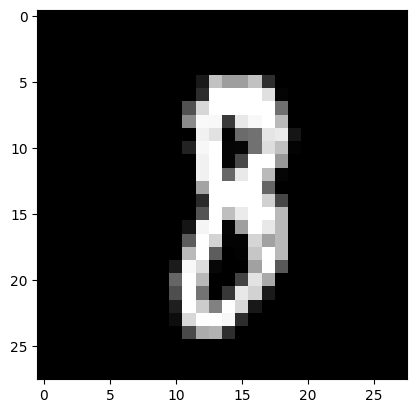

Prediction:  [2]
Label:  2


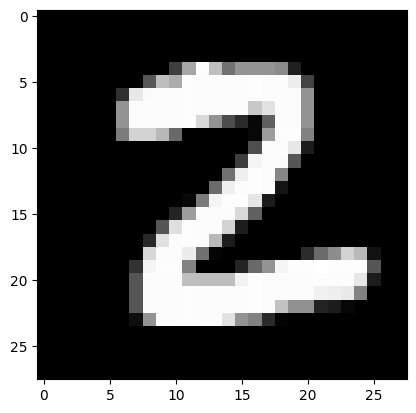

Prediction:  [6]
Label:  6


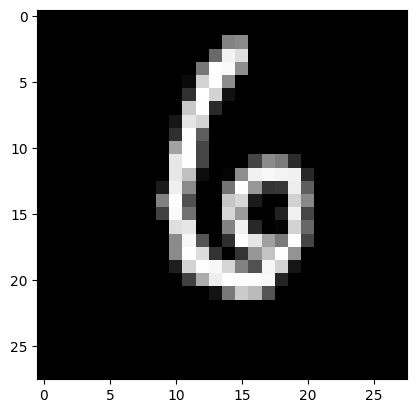

Prediction:  [0]
Label:  0


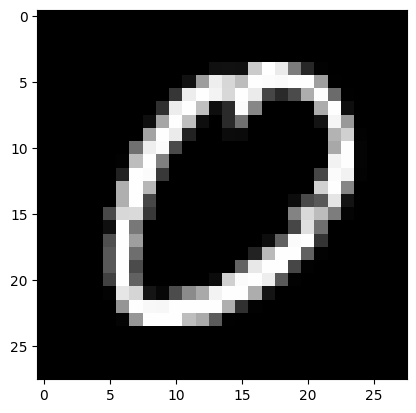

In [93]:
test_prediction(0, params)
test_prediction(1, params)
test_prediction(2, params)
test_prediction(3, params)

In [94]:
val_predictions = make_predictions(X_val, params)
get_accuracy(val_predictions, Y_val)

DeviceArray(0.9110001, dtype=float32)

In [95]:
input_example = X_train[None, 0].reshape(1, 1, 28, 28)

In [96]:
forward = partial(forward_fn.apply, params, rng_key)
out_jax = forward(input_example)
out_jax

DeviceArray([[1.65264704e-04, 7.90859107e-03, 1.62637513e-02,
              3.52185518e-01, 4.24381054e-04, 1.03837345e-02,
              4.48229781e-04, 8.14187527e-02, 4.60044712e-01,
              7.07571208e-02]], dtype=float32)

In [97]:
# NOTE: We need enable_xla=False because tf2onnx is not aware of some XLA
#       specific TF ops (e.g. DotGeneral).
forward_tf = tf.function(jax2tf.convert(forward, enable_xla=False))

In [109]:
input_signature = [tf.TensorSpec(input_example.shape, input_example.dtype, name="Input3")]
input_signature

[TensorSpec(shape=(1, 1, 28, 28), dtype=tf.float32, name='Input3')]

In [110]:
model_proto, external_tensor_storage = tf2onnx.convert.from_function(forward_tf, input_signature)

In [161]:
onnx_model = onnx.load_model_from_string(model_proto.SerializeToString())
onnx.checker.check_model(onnx_model)

In [162]:
endpoint_names = ['Identity_1:0']

for i in range(len(onnx_model.graph.node)):
	for j in range(len(onnx_model.graph.node[i].output)):
		if onnx_model.graph.node[i].output[j] in endpoint_names:
			print('-'*60)
			print(onnx_model.graph.node[i].name)
			print(onnx_model.graph.node[i].input)
			print(onnx_model.graph.node[i].output)

			onnx_model.graph.node[i].output[j] = "Plus214_Output_0"

for i in range(len(onnx_model.graph.output)):
	if onnx_model.graph.output[i].name in endpoint_names:
		print('-'*60)
		print(onnx_model.graph.output[i])
		onnx_model.graph.output[i].name = "Plus214_Output_0"

------------------------------------------------------------
jax2tf_unknown_/sequential/jit_true_divide_/truediv
['jax2tf_unknown_/sequential/jit__lambda__/Exp:0', 'jax2tf_unknown_/sequential/jit__reduce_sum_/BroadcastTo:0']
['Identity_1:0']
------------------------------------------------------------
name: "Identity_1:0"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 10
      }
    }
  }
}



In [163]:
onnx_model.graph.output

[name: "Plus214_Output_0"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 10
      }
    }
  }
}
]

In [164]:
x_np = jax.device_get(input_example)

In [165]:
sess = ort.InferenceSession(model_proto.SerializeToString())
out_ort, = sess.run(None, {"Input3": x_np})
out_ort

array([[1.6526482e-04, 7.9085967e-03, 1.6263761e-02, 3.5218531e-01,
        4.2438076e-04, 1.0383740e-02, 4.4822984e-04, 8.1418768e-02,
        4.6004480e-01, 7.0757098e-02]], dtype=float32)

In [166]:
out_jax

DeviceArray([[1.65264704e-04, 7.90859107e-03, 1.62637513e-02,
              3.52185518e-01, 4.24381054e-04, 1.03837345e-02,
              4.48229781e-04, 8.14187527e-02, 4.60044712e-01,
              7.07571208e-02]], dtype=float32)

In [167]:
np.testing.assert_allclose(out_ort, out_jax, rtol=0.00001)

In [168]:
input_names = [i.name for i in sess.get_inputs()]
output_names = [o.name for o in sess.get_outputs()]
print("inputs=%r, outputs=%r" % (input_names, output_names))

inputs=['Input3'], outputs=['Identity_1:0']


In [169]:
onnx.save(onnx_model, "./data/haiku_model.onnx")